# **Uncovering Patterns: Predicting Gameplay Hours with kNN Regression** #

By: Emma Savu (51050300), Sharon Kim (44152585), Anna Divinagracia (86144250), and Liam Sisson (54274535)

 # **Introduction** #

##### In this project, our goal is to answer the question:

**Which set of two variables is best at accurately predicting a player's played hours using k-nearest neighbours (kNN) regression?**

For some background, in machine learning, regression techniques are widely used to predict numerical outcomes based on one or more input variables. Among these methods, k-nearest neighbors (kNN) regression is a non-parametric approach that predicts the target variable by averaging the values of the k-closest data points in the feature space. kNN regression is valued for its simplicity, effectiveness, and ability to capture nonlinear relationships without assuming a specific model structure.

In this project, we applied kNN regression to explore how well different pairs of variables can predict a player's total hours played in a gaming dataset. The goal was to determine which combination of two variables provides the most accurate predictions of hours played, enabling more informed decision-making or targeted interventions in gaming analytics.

To answer our question, we combined the `sessions.csv` and the `players.csv` datasets, which contain information about individual players in an unspecified gaming context. The datasets include multiple features we can use, such as age, skill level, gender, played hours, time of day played, and start and end times. These variables potentially influence a player’s overall engagement, measured as hours played. By selecting specific pairs of these features, we sought to identify which combinations provide the strongest predictive power for hours played. We will convert the categorical variables to numerical numbers to analyze our model.

This analysis highlights the strengths and limitations of kNN regression and emphasizes the importance of feature selection in predictive modelling. Ultimately, the results can inform how we interpret player behaviour and optimize predictions in similar datasets.

The variables in the `players` dataset containing 196 observations can be described as follows:

- `experience`: character variable indicating player skill level/experience
- `subscribe`: logical variable (binary) for email subscription status
- `hashedEmail`: character variable, unique player identifier
- `played_hours`: double precision, hours played to the tenth decimal
- `name`: character variable for player's name
- `gender`: character variable with 7 unique gender categories
- `age`: double precision for player’s age in years
- `individualId`: logical variable for player ID
- `organizationName`: logical variable for player's organization

Furthermore, the variables in the `sessions` dataset containing 1535 observations can be described as:

- `hashedEmail`: character variable, unique player identifier
- `start_time`: character variable for start date in DD/MM/YYYY and start time in 00:00 of the player's game session
- `end_time`: character variable for end date in DD/MM/YYYY and end time in 00:00 of the player's game session
- `original_start_time`: double data type for start time in UNIX timestamp format of the player's game session
- `original_end_time`: double data type for end time in UNIX timestamp format of the player's game session

# **Methods** #

In [12]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 6)

In [13]:
players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz") |>
    select(-name, -individualId, -organizationName) |>    # removed columns not needed for analysis
    mutate(subscribe = case_when(subscribe == FALSE ~ 0,
                                 subscribe == TRUE ~ 1)) |>
    mutate(Beginner = ifelse(experience=="Beginner",1,0))|>
    mutate(Amateur = ifelse(experience=="Amateur",1,0))|>
    mutate(Regular = ifelse(experience=="Regular",1,0))|>
    mutate(Veteran = ifelse(experience=="Veteran",1,0)) |>
    mutate(Pro = ifelse(experience=="Pro",1,0))|>
    mutate(Male = ifelse(gender == "Male",1,0))|>
    mutate(Female = ifelse(gender == "Female",1,0))|>
    mutate(Non_binary = ifelse(gender == "Non-binary",1,0))|>
    mutate(prefer_not_to_say = ifelse(gender == "refer not to say",1,0))|>
    mutate(Agender = ifelse(gender == "Agender",1,0))|>
    mutate(Two_Spirited = ifelse(gender == "Two-Spirited",1,0))|>
    mutate(Other = ifelse(gender == "Other",1,0))
                            
players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,gender,age,Beginner,Amateur,Regular,Veteran,Pro,Male,Female,Non_binary,prefer_not_to_say,Agender,Two_Spirited,Other
<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pro,1,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9,0,0,0,0,1,1,0,0,0,0,0,0
Veteran,1,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17,0,0,0,1,0,1,0,0,0,0,0,0
Veteran,0,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17,0,0,0,1,0,1,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,0,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Prefer not to say,17,0,1,0,0,0,0,0,0,0,0,0,0
Amateur,0,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Male,17,0,1,0,0,0,1,0,0,0,0,0,0
Pro,1,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Other,91,0,0,0,0,1,0,0,0,0,0,0,1


In [14]:
# define find_mode function
find_mode <- function(x) {        # Defines a function `find_mode` that takes a single input `x`.
    u <- unique(x)                # Creates a vector `u` of the unique values in `x`.
    tab <- tabulate(match(x, u))  # Counts the occurrences of each unique value in `x` by mapping `x` to the positions of `u`.
    u[tab == max(tab)]            # Returns the value(s) in `u` corresponding to the maximum frequency in `tab`.
}

# load and wrangle sessions data set
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB") |>
    select(-original_start_time, -original_end_time) |>                                      # remove columns in UNIX time format
    mutate(start_time = format(strptime(start_time, "%d/%m/%Y %H:%M"), "%H:%M:%S")) |>       # format start_time into time format
    mutate(end_time = format(strptime(end_time, "%d/%m/%Y %H:%M"), "%H:%M:%S")) |>           # format end_time into time format
    mutate(time_of_day = case_when(start_time >= "00:00:00" & start_time < "06:00:00" ~ 1,
                                   start_time >= "06:00:00" & start_time < "12:00:00" ~ 2,
                                   start_time >= "12:00:00" & start_time < "18:00:00" ~ 3,
                                   start_time >= "18:00:00" & start_time <= "23:59:59" ~ 4)) |>

    group_by(hashedEmail) |> 
    summarize(mode_time_of_day = find_mode(time_of_day))

sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'hashedEmail'. You can override using the
`.groups` argument.


hashedEmail,mode_time_of_day
<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,4
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,1
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,3
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,2


In [15]:
combined <- merge(sessions, players, by = "hashedEmail") |>
    select(-hashedEmail,-experience, -gender)
combined

mode_time_of_day,subscribe,played_hours,age,Beginner,Amateur,Regular,Veteran,Pro,Male,Female,Non_binary,prefer_not_to_say,Agender,Two_Spirited,Other
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,1,1.5,20,0,0,1,0,0,1,0,0,0,0,0,0
1,1,1.5,20,0,0,1,0,0,1,0,0,0,0,0,0
1,0,0.4,21,0,0,0,0,1,1,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1,56.1,23,0,1,0,0,0,1,0,0,0,0,0,0
3,1,0.1,17,0,1,0,0,0,1,0,0,0,0,0,0
2,1,1.1,20,1,0,0,0,0,1,0,0,0,0,0,0


In [17]:
# Creating training and testing split 
split <- initial_split(combined, prop= 0.75, strata = played_hours)
combined_training <- training(split)
combined_testing <- testing(split)
head(combined_testing)

,mode_time_of_day,subscribe,played_hours,age,Beginner,Amateur,Regular,Veteran,Pro,Male,Female,Non_binary,prefer_not_to_say,Agender,Two_Spirited,Other
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,5.6,17,0,0,1,0,0,1,0,0,0,0,0,0
2,1,0,0.0,26,0,1,0,0,0,0,0,0,0,0,1,0
3,1,1,53.9,17,0,1,0,0,0,1,0,0,0,0,0,0
4,2,0,0.1,17,0,0,0,1,0,1,0,0,0,0,0,0
5,1,1,0.4,20,0,0,0,1,0,1,0,0,0,0,0,0
6,4,1,0.4,20,0,0,0,1,0,1,0,0,0,0,0,0


.pred,mode_time_of_day,subscribe,played_hours,age,Beginner,Amateur,Regular,Veteran,Pro,Male,Female,Non_binary,prefer_not_to_say,Agender,Two_Spirited,Other
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.2422326,4,1,0.1,17,1,0,0,0,0,1,0,0,0,0,0,0
10.6475973,2,0,0.1,19,0,0,0,1,0,1,0,0,0,0,0,0
10.6475973,2,0,0.0,21,0,1,0,0,0,1,0,0,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
16.0925123,1,1,150.0,16,0,1,0,0,0,0,1,0,0,0,0,0
-0.2422326,4,1,3.5,21,0,1,0,0,0,0,1,0,0,0,0,0
16.0925123,1,1,56.1,23,0,1,0,0,0,1,0,0,0,0,0,0


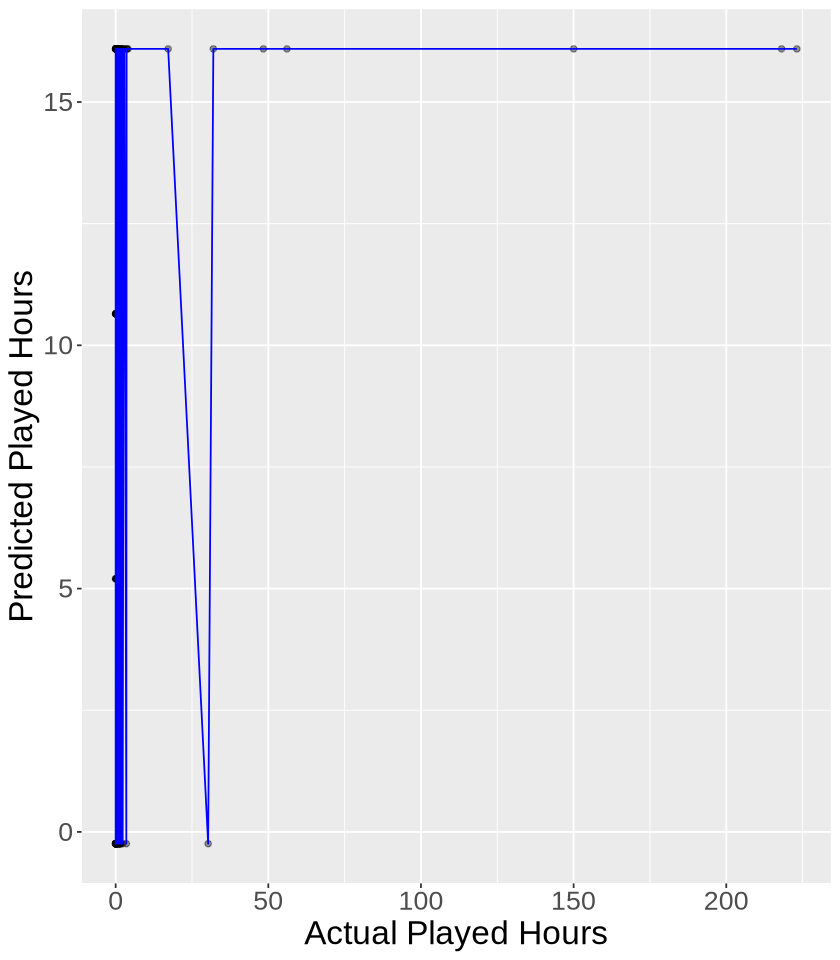

In [20]:
options(repr.plot.height = 8, repr.plot.width = 7)

combined_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")

combined_recipe <- recipe(played_hours ~ mode_time_of_day, beginner:pro, data = combined_training)

combined_fit <- workflow() |>
            add_recipe(combined_recipe) |>
            add_model(combined_spec) |>
            fit(data = combined_training)

combined_preds <- combined_fit |>
  predict(combined_training) |>
  bind_cols(combined_training)

combined_predictions <- combined_preds |>
    ggplot(aes(x = played_hours, y = .pred)) +  
        geom_point(alpha = 0.4) +
        geom_line(color = "blue") +
        xlab("Actual Played Hours") +  
        ylab("Predicted Played Hours") +  
        theme(text = element_text(size = 20))

combined_predictions

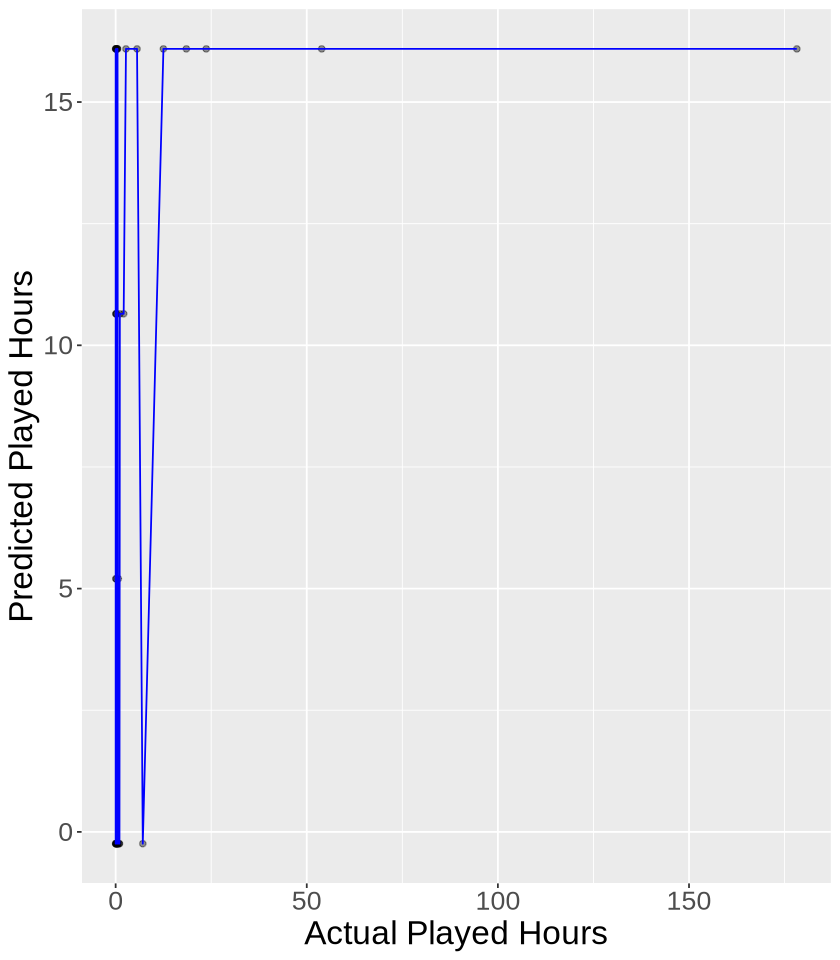

In [19]:
lm_test_results <- combined_fit |>
                    predict(combined_testing) |>
                    bind_cols(combined_testing) |>
                    metrics(truth = played_hours, estimate = .pred)                    

lm_rmspe <- lm_test_results |>
                filter(.metric == 'rmse') |>
                select(.estimate) |>
                pull()

test_preds <- combined_fit |>
    predict(combined_testing) |>
    bind_cols(combined_testing)

lm_predictions_test <- test_preds |>
    ggplot(aes(x = played_hours, y = .pred)) +  
        geom_point(alpha = 0.4) +
        geom_line(color = "blue") +
        xlab("Actual Played Hours") +  
        ylab("Predicted Played Hours") +  
        theme(text = element_text(size = 20))

lm_predictions_test

In [5]:
# load and wrangle players data set
players <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz") |>
    select(-name, -individualId, -organizationName) |>    # removed columns not needed for analysis
    mutate(experience = case_when(experience == "Beginner" ~ 1,
                                  experience == "Amateur" ~ 2,
                                  experience == "Regular" ~ 3,
                                  experience == "Veteran" ~ 4,
                                  experience == "Pro" ~ 5)) |> 
    mutate(subscribe = case_when(subscribe == FALSE ~ 0,
                                 subscribe == TRUE ~ 1)) |>
    mutate(gender = case_when(gender == "Male" ~ 1,
                              gender == "Female" ~ 2,
                              gender == "Non-binary" ~ 3,
                              
                              gender == "Prefer not to say" ~ 4,
                              gender == "Agender" ~ 5,
                              gender == "Two-Spirited" ~ 6,
                              gender == "Other" ~ 7))

# 'mutate' converts the experience column from categorical (character) to numerical values based on the experienc elevel

players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,gender,age
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
5,1,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,1,9
4,1,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,1,17
4,0,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,1,17
⋮,⋮,⋮,⋮,⋮,⋮
2,0,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,4,17
2,0,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,1,17
5,1,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,7,91


In [6]:
# define find_mode function
find_mode <- function(x) {        # Defines a function `find_mode` that takes a single input `x`.
    u <- unique(x)                # Creates a vector `u` of the unique values in `x`.
    tab <- tabulate(match(x, u))  # Counts the occurrences of each unique value in `x` by mapping `x` to the positions of `u`.
    u[tab == max(tab)]            # Returns the value(s) in `u` corresponding to the maximum frequency in `tab`.
}

# load and wrangle sessions data set
sessions <- read_csv("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB") |>
    select(-original_start_time, -original_end_time) |>                                      # remove columns in UNIX time format
    mutate(start_time = format(strptime(start_time, "%d/%m/%Y %H:%M"), "%H:%M:%S")) |>       # format start_time into time format
    mutate(end_time = format(strptime(end_time, "%d/%m/%Y %H:%M"), "%H:%M:%S")) |>           # format end_time into time format
    mutate(time_of_day = case_when(start_time >= "00:00:00" & start_time < "06:00:00" ~ 1,
                                   start_time >= "06:00:00" & start_time < "12:00:00" ~ 2,
                                   start_time >= "12:00:00" & start_time < "18:00:00" ~ 3,
                                   start_time >= "18:00:00" & start_time <= "23:59:59" ~ 4)) |> 
    group_by(hashedEmail) |> 
    summarize(mode_time_of_day = find_mode(time_of_day))

sessions

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'hashedEmail'. You can override using the
`.groups` argument.


hashedEmail,mode_time_of_day
<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,4
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,1
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,1
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,3
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,2


In [7]:
# Combine data tables
combined <- merge(sessions, players, by = "hashedEmail") |>
    select(-hashedEmail)
combined

mode_time_of_day,experience,subscribe,played_hours,gender,age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,3,1,1.5,1,20
1,3,1,1.5,1,20
1,5,0,0.4,1,21
⋮,⋮,⋮,⋮,⋮,⋮
1,2,1,56.1,1,23
3,2,1,0.1,1,17
2,1,1,1.1,1,20


In [8]:
# Creating training and testing split 
split <- initial_split(combined, prop= 0.75, strata = played_hours)
combined_training <- training(split)
combined_testing <- testing(split)
head(combined_testing)

,mode_time_of_day,experience,subscribe,played_hours,gender,age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,1,0.7,2,21
2,2,2,0,0.0,1,21
3,1,2,1,32.0,1,22
4,1,3,1,4.0,1,21
5,1,2,1,53.9,1,17
6,2,2,1,0.2,1,22


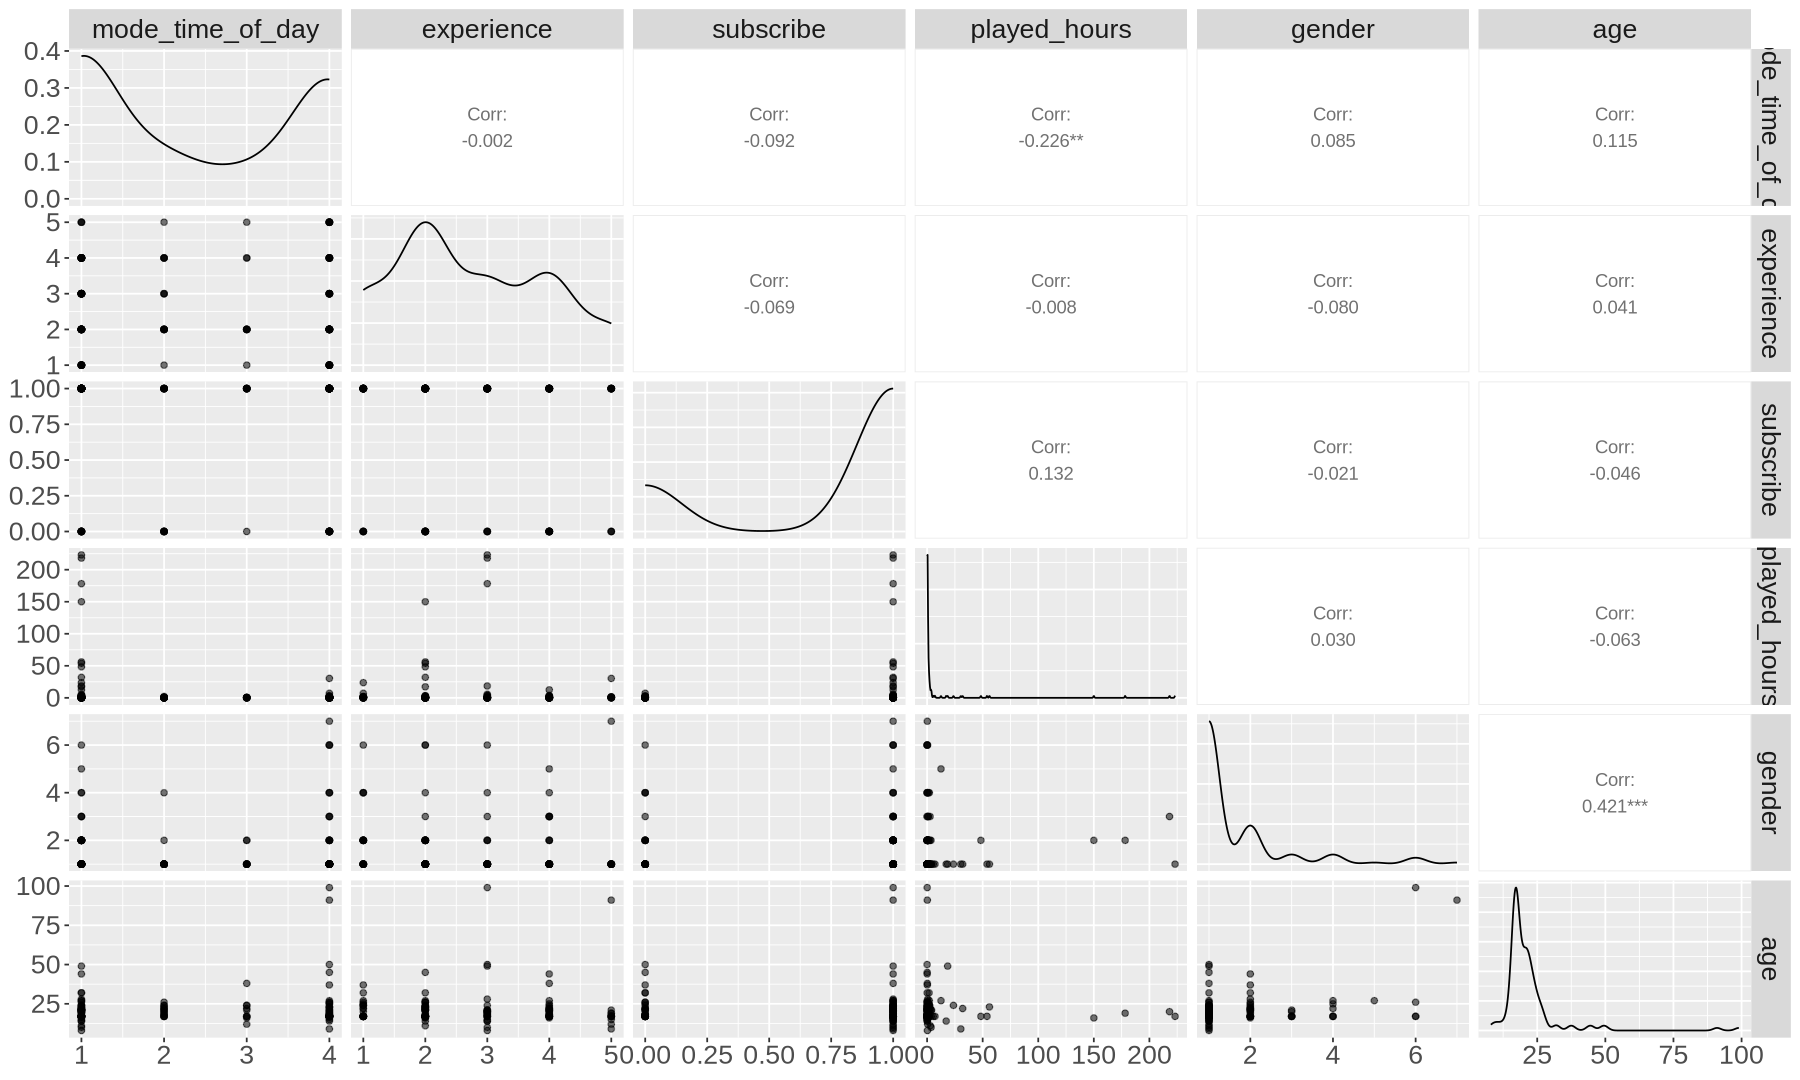

In [9]:
options(repr.plot.width = 15, repr.plot.height = 9)

combined_pairs <- combined |> 
    ggpairs(aes(alpha = 0.2)) +
    theme(text = element_text(size = 20))

combined_pairs

**Based on this graph, we can figure out which pairs of data is best to use for the kNN regression based on their correlation (and significance) as well as practicality**

To find the best pair of variables for predicting gameplay hours using kNN regression, we looked at the ggpairs graph to analyze correlations and patterns. We chose `mode_time_of_day` because it had a weak but significant negative correlation with `played_hours` (-0.226**), suggesting it might still have useful information. We also picked `experience` because it shows player skill levels, which could help explain gameplay behavior, even though its correlation was very low (-0.008). This variable also has a large array of values (1-5). This dataset is also well balanced with a similar amount of values for each experience level. These two variables work well together because they capture different aspects of when players are active and how skilled they are making them a strong pair for kNN regression.

The other variables that are not in the pair are: `subscribe`, `gender` and `age` for these reasons:

Subscribe: 
- The correlation with `played_hours` is weak (0.132) and not statistically significant. This suggests that whether a user subscribes or not does not strongly affect the amount of time they play, making it a less useful predictor in this case as well is it being a binary variable (1 or 0)
- The scatterplot does not show a clear trend, further indicating that it may not have a strong relationship with gameplay hours.

Gender:
- The correlation with `played_hours` is also weak and insignificant (0.030), which suggests there is little to no relationship between gender and how much time a player spends playing.
- Since gender is a categorical variable with low correlation to the target, it may not contribute meaningful predictive power for this analysis.

Age: 
- The correlation between age and `played_hours` is very weak and insignificant(-0.063), indicating almost no relationship. The scatterplot also shows little to no trend, making age an unlikely predictor of gameplay hours in this case.
- Age might be influenced by other factors like experience or time of day, which are already being considered, so adding it may not provide additional valuable information.

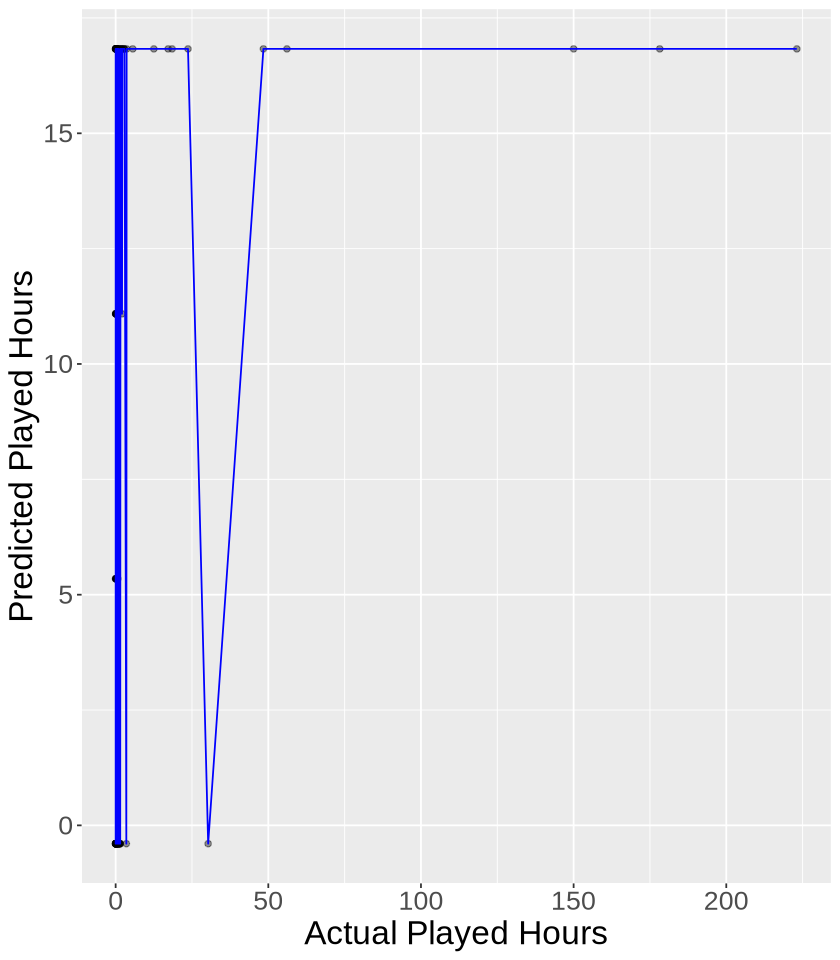

In [12]:
options(repr.plot.height = 8, repr.plot.width = 7)

combined_spec <- linear_reg() |>
            set_engine("lm") |>
            set_mode("regression")

combined_recipe <- recipe(played_hours ~ mode_time_of_day, experience, data = combined_training)

combined_fit <- workflow() |>
            add_recipe(combined_recipe) |>
            add_model(combined_spec) |>
            fit(data = combined_training)

combined_preds <- combined_fit |>
  predict(combined_training) |>
  bind_cols(combined_training)

combined_predictions <- combined_preds |>
    ggplot(aes(x = played_hours, y = .pred)) +  
        geom_point(alpha = 0.4) +
        geom_line(color = "blue") +
        xlab("Actual Played Hours") +  
        ylab("Predicted Played Hours") +  
        theme(text = element_text(size = 20))

combined_predictions

# Do i need to filter the data set before this part??

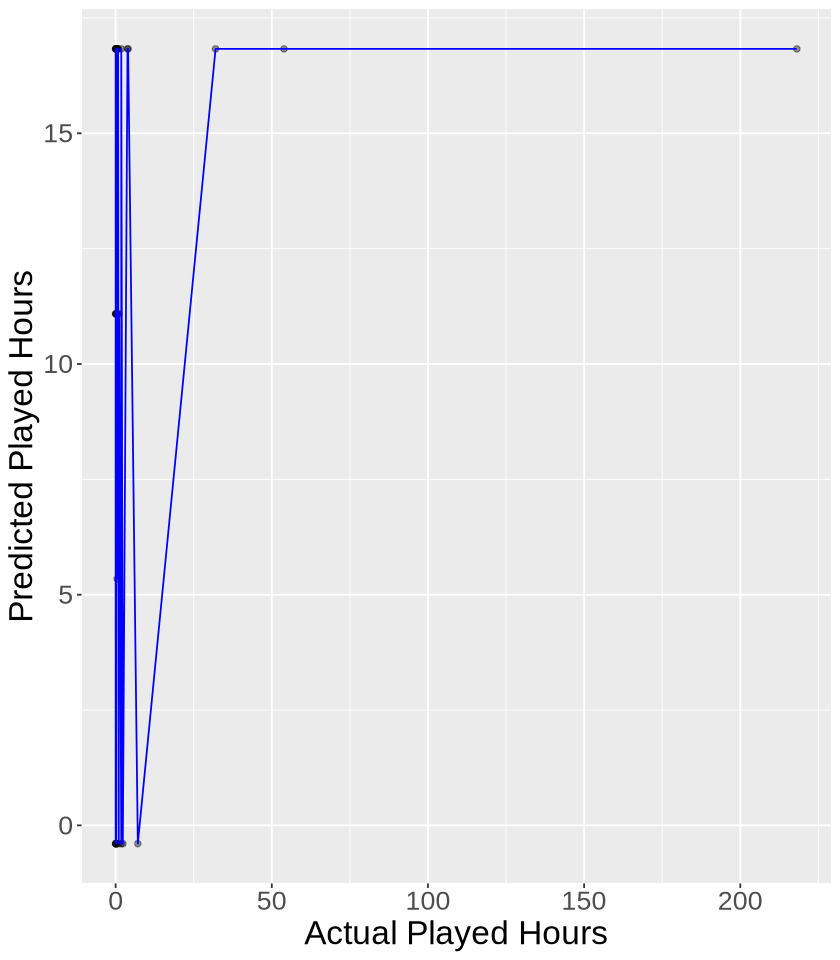

In [14]:
lm_test_results <- combined_fit |>
                    predict(combined_testing) |>
                    bind_cols(combined_testing) |>
                    metrics(truth = played_hours, estimate = .pred)                    

lm_rmspe <- lm_test_results |>
                filter(.metric == 'rmse') |>
                select(.estimate) |>
                pull()

test_preds <- combined_fit |>
    predict(combined_testing) |>
    bind_cols(combined_testing)

lm_predictions_test <- test_preds |>
    ggplot(aes(x = played_hours, y = .pred)) +  
        geom_point(alpha = 0.4) +
        geom_line(color = "blue") +
        xlab("Actual Played Hours") +  
        ylab("Predicted Played Hours") +  
        theme(text = element_text(size = 20))

lm_predictions_test

# **Results** ##

# **Discussion** #

# **References** #

https://scales.arabpsychology.com/stats/how-to-perform-one-hot-encoding-in-r/


https://www.kaggle.com/code/mlomuscio/tutorial-one-hot-encoding-in-r